In [174]:
import Quandl
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd

In [175]:
def num_to_str(num): return str(num).replace('-', 'm')

In [176]:
def get_data(ticker):
    df = Quandl.get('WIKI/{}'.format(ticker))
    df = df[['Adj. Close', 'Adj. Volume']]
    df.rename(columns={'Adj. Close': 'price', 'Adj. Volume': 'volume'}, inplace=True)
    return df

def build_features(df):
    for i in [-200, -20, -5, -1, 5, 20]: 
        df['price_'+num_to_str(i)] = df['price'].shift(-i)
        if i < 0: df['price_ch_'+num_to_str(i)] = df['price'] / df['price_'+num_to_str(i)] - 1
        else: df['price_ch_'+num_to_str(i)] = df['price_'+num_to_str(i)] / df['price'] - 1
            
    # features
    df['price_rolling_mean_m200'] = df['price'].rolling(window=200).mean()
    df['price_rolling_mean_m20'] = df['price'].rolling(window=20).mean()
    df['price_m20_m200'] = df['price_rolling_mean_m20'] / df['price_rolling_mean_m200']

    df['price_rolling_std_m200'] = df['price_ch_m1'].rolling(window=20).std()
    df['price_rolling_std_m20'] = df['price_ch_m1'].rolling(window=5).std()
    df['std_m20_m200'] = df['price_rolling_std_m20'] / df['price_rolling_std_m200']

    df['volume_rolling_mean_m200'] = df['volume'].rolling(window=200).mean()
    df['volume_rolling_mean_m20'] = df['volume'].rolling(window=20).mean()
    df['vol_m20_m200'] = df['volume_rolling_mean_m20'] / df['volume_rolling_mean_m200']
    
    # labels
    df['fwd_std_m20'] = df['price_rolling_std_m20'].shift(-20)
    df['fwd_volume_m20'] = df['volume_rolling_mean_m20'].shift(-20)
    
    return df.dropna()

def run_rolling(features, predict, model, df, rolling_period):
    for y in range(df.index.min().year + rolling_period, df.index.max().year + 1): 
        df_train = df[(df.index.year >= y - rolling_period) & (df.index.year < y)]
        df_test = df[df.index.year == y]
        clf = model()
        clf.fit(df_train[features], df_train[predict_field])
        df_test['predicted'] = clf.predict(df_test[features])
        df.ix[df_test.index, 'predicted'] = df_test.predicted
    return df

# simple
# clf = GradientBoostingRegressor()
# clf.fit(df[features], df[predict_field])
# df['predicted'] = clf.predict(df[features])

In [177]:
tickers = ['MSFT', 'AAPL']

In [178]:
ticker = 'MSFT'
predict_field = 'fwd_std_m20'
benchmark_field = 'price_rolling_std_m20'
features = ['price_m20_m200', 'std_m20_m200', 'vol_m20_m200', 'price_rolling_std_m20', 'volume_rolling_mean_m20']
rolling_period = 10

In [179]:
df = get_data(ticker)
df =  build_features(df)
df = run_rolling(features=features, predict=predict_field, model=GradientBoostingRegressor, df=df, 
                 rolling_period=rolling_period)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [180]:
df[['predicted', predict_field, benchmark_field]].corr()[predict_field]

predicted                0.351193
fwd_std_m20              1.000000
price_rolling_std_m20    0.311950
Name: fwd_std_m20, dtype: float64

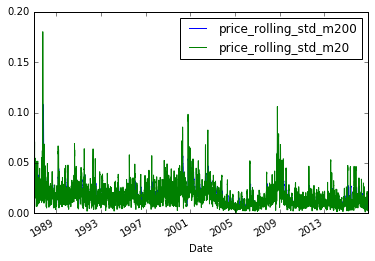

In [185]:
df[['price_rolling_std_m200', 'price_rolling_std_m20']].plot()

In [183]:
%matplotlib inline